# The `opencadd.databases.klifs` module

The `opencadd.databases.klifs` module offers to interact with KLIFS data 

- __locally__ ([KLIFS data download](https://klifs.vu-compmedchem.nl/search.php)) and
- __remote__ ([KLIFS swagger API](https://klifs.vu-compmedchem.nl/swagger/))  

following the same API in its `local` and `remote` modules.

In the following, the API will be demonstrated in parallel for local and remote access for the following sources of information (classes in `local` and `remote` modules):

- `Kinases`: Details on kinases in KLIFS
- `Ligands`: Details on ligands in KLIFS
- `Structures`  Details on structures in KLIFS (extracted from the PDB)
- `Bioactivities` (accessible only remotely): Details on bioactivities in KLIFS (extracted from ChEMBL)
- `Interactions`: Details on kinase-ligand interactions in KLIFS
- `Pockets`: Details on kinase pockets in KLIFS
- `Coordinates`: Coordinates for complexes, ligands, pockets, proteins, and water in KLIFS

The module structure is defined as follows:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from bravado_core.exception import SwaggerMappingError
import pandas as pd
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [3]:
pd.set_option("display.max_rows", 5)

## Set up remote and local session

From the `api` module, import the session setup functions `setup_remote()` and `setup_local()`.

In [4]:
from opencadd.databases.klifs.api import setup_remote, setup_local

### Remote session

Set up a __remote session__ to work with remote KLIFS data (access via the KLIFS swagger API).

In [5]:
remote = setup_remote()
print(remote.session_type)

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


remote


In [6]:
remote.client

SwaggerClient(http://klifs.vu-compmedchem.nl/api)

### Local session

Set up a __local session__ to work with local KLIFS data (access to a KLIFS download folder).

In [7]:
local = setup_local("../../opencadd/tests/databases/data/KLIFS_download")
print(local.session_type)

INFO:opencadd.databases.klifs.api:Set up local session...
INFO:opencadd.databases.klifs.local:Load overview.csv...
INFO:opencadd.databases.klifs.local:Load KLIFS_export.csv...
INFO:opencadd.databases.klifs.local:Merge both csv files...
INFO:opencadd.databases.klifs.local:Add paths to coordinate folders to structures...
INFO:opencadd.databases.klifs.local:Add KLIFS IDs to structures...
INFO:opencadd.databases.klifs.api:Local session is ready!


local


The `setup_local` function will initialize a __database__ (a `pandas.DataFrame`), describing the metadata of structures contained in the KLIFS download.

In [8]:
local.database

,species.klifs,structure.pdb,structure.alternate_model,structure.chain,ligand.pdb,ligand.pdb_allosteric,structure.rmsd1,structure.rmsd2,structure.qualityscore,kinase.pocket,structure.resolution,structure.missing_residues,structure.missing_atoms,interaction.fingerprint,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,kinase.name,kinase.name_all,kinase.family,kinase.group,ligand.name,ligand.name_allosteric,structure.dfg,structure.ac_helix,structure.filepath,structure.id,kinase.id
0,Human,3sxr,-,A,1N1,-,0.839,1.967,6.4,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,2.40,4,0,0000000000000010000001000000000000000000000000...,0,0,1,1,0,0,0,0,0,0,0,0,BMX,[BMX],Tec,TK,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,HUMAN/BMX/3sxr_chainA,3482,472
1,Human,6uuo,-,A,QH1,-,0.806,2.028,5.2,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,3.29,7,61,0000000000000000000000000000000000000000000000...,0,0,1,1,1,1,0,0,0,0,0,0,BRAF,[BRAF],RAF,TKL,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,-,in,out-like,HUMAN/BRAF/6uuo_chainA,12347,509
2,Mouse,1fpu,-,A,PRC,-,0.925,2.319,8.8,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.40,0,8,0000000000000010000000000000000000000000000000...,0,0,1,1,0,0,0,1,0,0,0,0,Abl1,"[Abl1, ABL1]",Abl,TK,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,MOUSE/Abl1/1fpu_chainA,5728,532
3,Mouse,1fpu,-,B,PRC,-,0.925,2.329,9.2,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.40,0,4,0000000000000010000000000000000000000000000000...,0,0,0,1,0,0,0,1,0,0,0,0,Abl1,"[Abl1, ABL1]",Abl,TK,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,MOUSE/Abl1/1fpu_chainB,5705,532


### Access information

Different sources of information are accessible via (instances of classes introduced earlier, which are initialized upon session setup):

- `local.kinases` or `remote.kinases`
- `local.ligands` or `remote.ligands`
- `local.structures` or `remote.structures`
- `local.bioactivities` or `remote.bioactivities`
- `local.interactions` or `remote.interactions`
- `local.pockets` or `remote.pockets`
- `local.coordinates` or `remote.coordinates`

## Kinases

Explore access to kinase information.

### All kinase groups

__Remote__

In [9]:
remote.kinases.all_kinase_groups()

,kinase.group
0,AGC
1,CAMK
...,...
6,TK
7,TKL


__Local__

In [10]:
local.kinases.all_kinase_groups()

,kinase.group
0,TK
1,TKL


### All kinase families (in a kinase group)

__Remote__

In [11]:
remote.kinases.all_kinase_families()

,kinase.family
0,A6
1,ABC1
...,...
142,Wnk
143,YANK


In [12]:
remote.kinases.all_kinase_families(group='TK')

,kinase.family
0,ALK
1,Abl
...,...
29,Trk
30,VEGFR


In [13]:
try:
    remote.kinases.all_kinase_families(group='XXX')
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: A provided group does not exist.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [14]:
local.kinases.all_kinase_families()

,kinase.family
0,Tec
1,RAF
2,Abl


In [15]:
local.kinases.all_kinase_families(group='TK')

,kinase.family
0,Tec
1,Abl


In [16]:
try:
    local.kinases.all_kinase_families('XXX')
except ValueError as e:
    print(e)

Input values yield no results.


### All kinase names

__Remote__

In [17]:
remote.kinases.all_kinases()

,kinase.id,kinase.name,kinase.name_full,species.klifs
0,813,4921509C19Rik,RIKEN cDNA 4921509C19 gene,Mouse
1,815,4921509C19Rik,RIKEN cDNA 4921509C19 gene,Mouse
...,...,...,...,...
1125,529,A6,0,Mouse
1126,530,A6r,0,Mouse


In [18]:
remote.kinases.all_kinases(group='TK', family='Tec', species="Mouse")

,kinase.id,kinase.name,kinase.name_full,species.klifs
0,574,Bmx,BMX non-receptor tyrosine kinase,Mouse
1,583,Btk,Bruton agammaglobulinemia tyrosine kinase,Mouse
2,739,Itk,IL2 inducible T cell kinase,Mouse
3,1008,Tec,tec protein tyrosine kinase,Mouse
4,1039,Txk,TXK tyrosine kinase,Mouse


In [19]:
try:
    remote.kinases.all_kinases(group='XXX')
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: A provided group does not exist.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [20]:
local.kinases.all_kinases(family="Tec")

,kinase.name,species.klifs
0,BMX,Human


In [21]:
local.kinases.all_kinases(family="Abl", species="Mouse")

,kinase.name,species.klifs
0,Abl1,Mouse


In [22]:
try:
    local.kinases.all_kinases(group='XXX')
except ValueError as e:
    print(e)

Input values yield no results.


### Kinase by kinase ID

__Remote__

In [23]:
remote.kinases.from_kinase_ids(1)

,kinase.id,kinase.name,kinase.hgnc,kinase.family,kinase.group,kinase.class,species.klifs,kinase.name_full,kinase.uniprot,kinase.iuphar,kinase.pocket
0,1,AKT1,AKT1,Akt,AGC,,Human,v-akt murine thymoma viral oncogene homolog 1,P31749,1479,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...


In [24]:
remote.kinases.from_kinase_ids([1,2,10000])

,kinase.id,kinase.name,kinase.hgnc,kinase.family,kinase.group,kinase.class,species.klifs,kinase.name_full,kinase.uniprot,kinase.iuphar,kinase.pocket
0,1,AKT1,AKT1,Akt,AGC,,Human,v-akt murine thymoma viral oncogene homolog 1,P31749,1479,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...
1,2,AKT2,AKT2,Akt,AGC,,Human,v-akt murine thymoma viral oncogene homolog 2,P31751,1480,KLLGKGTFGKVILYAMKILHTVTESRVLQNTRPFLTALKYACFVME...


In [25]:
try:
    remote.kinases.from_kinase_ids(10000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown kinase ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

Not implemented yet.

### Kinase by kinase name (and species)

__Remote__

In [26]:
remote.kinases.from_kinase_names('BMX')

Processing BMX...: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


,kinase.id,kinase.name,kinase.hgnc,kinase.family,kinase.group,kinase.class,species.klifs,kinase.name_full,kinase.uniprot,kinase.iuphar,kinase.pocket
0,574,BMX,Bmx,Tec,TK,,Mouse,BMX non-receptor tyrosine kinase,P97504,0,KELGNGQFGVVQLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...
1,472,BMX,BMX,Tec,TK,,Human,BMX non-receptor tyrosine kinase,P51813,1942,KELGSGQFGVVQLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...


In [27]:
try:
    remote.kinases.from_kinase_names("BMX", species="Dog")
except SwaggerMappingError as e:
    print(e)

Processing BMX...: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s]
ERROR:opencadd.databases.klifs.core:There was (were) 1/1 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for BMX: Expected type to be dict for value [400, 'KLIFS error: The provided species does not exist. '] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


Input values yield no results.


In [28]:
remote.kinases.from_kinase_names(['BMX', 'BRAF', 'XXX'], species="Human")

Processing XXX...: 100%|██████████| 3/3 [00:00<00:00, 12.97it/s] 
ERROR:opencadd.databases.klifs.core:There was (were) 1/3 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for XXX: Expected type to be dict for value [400, 'KLIFS error: An unknown kinase name was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


,kinase.id,kinase.name,kinase.hgnc,kinase.family,kinase.group,kinase.class,species.klifs,kinase.name_full,kinase.uniprot,kinase.iuphar,kinase.pocket
0,472,BMX,BMX,Tec,TK,,Human,BMX non-receptor tyrosine kinase,P51813,1942,KELGSGQFGVVQLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...
1,509,BRAF,BRAF,RAF,TKL,RAF,Human,"B-Raf proto-oncogene, serine/threonine kinase",P15056,1943,QRIGSGSFGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...


__Local__

In [29]:
local.kinases.from_kinase_names('BMX')

,kinase.name,kinase.group,kinase.family,species.klifs,kinase.pocket
0,BMX,TK,Tec,Human,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...


In [30]:
try:
    local.kinases.from_kinase_names("BMX", species="Dog")
except ValueError as e:
    print(e)

Input values yield no results.


In [31]:
local.kinases.from_kinase_names(['BMX', 'BRAF', 'XXX'], species="Human")

,kinase.name,kinase.group,kinase.family,species.klifs,kinase.pocket
0,BMX,TK,Tec,Human,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...
1,BRAF,TKL,RAF,Human,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...


## Ligands

Explore access to ligand information.

### All ligands

__Remote__

In [32]:
remote.ligands.all_ligands()

,ligand.id,ligand.pdb,ligand.name,ligand.smiles,ligand.inchikey
0,1,IHZ,5-[(2-methyl-5-{[3-(trifluoromethyl)phenyl]car...,FC(F)(F)c1cc(NC(=O)c2cc(Nc3cncc(c3)C(=O)N)c(cc...,SAAYRHKJHDIDPH-UHFFFAOYSA-N
1,2,477,"3-{2-[5-(difluoromethyl)-2H-thieno[3,2-c]pyraz...",S1C=2C(=NNC2C=C1C(F)F)C=3Nc4c(ccc(c4)C(O)(CC)C...,CQZZZUNOWZUNNG-UHFFFAOYSA-N
...,...,...,...,...,...
3525,3814,IHH,[4-({4-[(5-cyclopropyl-1H-pyrazol-3-yl)amino]q...,N#CCc1ccc(Nc2nc(NC3=NNC(=C3)C4CC4)c5c(n2)cccc5...,InChI not available
3526,3815,V3S,"(2R)-N-{6-[4-(propan-2-yl)-4H-1,2,4-triazol-3-...",O=C(Nc1nc(ccc1)C2=NN=CN2C(C)C)[C@@H]3OCCCC3,InChI not available


__Local__

In [33]:
local.ligands.all_ligands()

,ligand.pdb,ligand.name
0,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...
1,QH1,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...
2,PRC,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...


### Ligands from kinase ID(s)

__Remote__

In [34]:
remote.ligands.from_kinase_ids(472)

Processing 472...: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


,ligand.id,ligand.pdb,ligand.name,ligand.smiles,ligand.inchikey,kinase.id (query)
0,281,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,Clc1c(NC(=O)C=2SC(=NC2)Nc3nc(nc(N4CCN(CCO)CC4)...,ZBNZXTGUTAYRHI-UHFFFAOYSA-N,472
1,632,PP2,1-TERT-BUTYL-3-(4-CHLORO-PHENYL)-1H-PYRAZOLO[3...,Clc1ccc(cc1)C2=[NH+]N(c3ncnc(N)c32)C(C)(C)C,PBBRWFOVCUAONR-UHFFFAOYSA-O,472
2,3716,H88,~{N}-[2-methyl-5-[8-[4-(methylsulfonylamino)ph...,S(=O)(=O)(Nc1ccc(c2cc3ncc4c(N(c5cc(NC(=O)CCO)c...,InChI not available,472


In [35]:
remote.ligands.from_kinase_ids([472, 509, 10000])

Processing 10000...: 100%|██████████| 3/3 [00:00<00:00, 10.31it/s]
ERROR:opencadd.databases.klifs.core:There was (were) 1/3 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 10000: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


,ligand.id,ligand.pdb,ligand.name,ligand.smiles,ligand.inchikey,kinase.id (query)
0,281,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,Clc1c(NC(=O)C=2SC(=NC2)Nc3nc(nc(N4CCN(CCO)CC4)...,ZBNZXTGUTAYRHI-UHFFFAOYSA-N,472
1,632,PP2,1-TERT-BUTYL-3-(4-CHLORO-PHENYL)-1H-PYRAZOLO[3...,Clc1ccc(cc1)C2=[NH+]N(c3ncnc(N)c32)C(C)(C)C,PBBRWFOVCUAONR-UHFFFAOYSA-O,472
...,...,...,...,...,...,...
62,3553,K7S,"N-[4-methyl-3-(1-methyl-2-oxo-2,3-dihydro-1H-b...",Cc1ccc(cc1c2ccc3c(c2)NC(=O)N3C)NC(=O)c4cccc(c4...,UUDBNZHNESYAMK-UHFFFAOYSA-N,509
63,3715,QH1,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,S(O)(O)(Nc1c(F)c(N2c3c(nc(N(C4C=CN(C(=O)C)C=C4...,InChI not available,509


In [36]:
try:
    remote.ligands.from_kinase_ids(10000)
except SwaggerMappingError as e:
    print(e)

Processing 10000...: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]
ERROR:opencadd.databases.klifs.core:There was (were) 1/1 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 10000: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


Input values yield no results.


__Local__

Not implemented yet.

### Ligands from kinase name(s)

__Remote__

In [37]:
remote.ligands.from_kinase_names(["ABL1", "BMX"])

Processing 472...: 100%|██████████| 4/4 [00:00<00:00,  9.53it/s]
ERROR:opencadd.databases.klifs.core:There was (were) 1/4 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 574: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


,ligand.id,ligand.pdb,ligand.name,ligand.smiles,ligand.inchikey,kinase.id (query),kinase.name (query),species.klifs (query)
0,26,ADP,ADENOSINE-5&apos;-DIPHOSPHATE,P(=O)(OP(=O)(O)O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c...,XTWYTFMLZFPYCI-KQYNXXCUSA-N,392,ABL1,Human
1,38,AGS,PHOSPHOTHIOPHOSPHORIC ACID-ADENYLATE ESTER,S=P(OP(=O)(OP(=O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c...,NLTUCYMLOPLUHL-KQYNXXCUSA-N,392,ABL1,Human
...,...,...,...,...,...,...,...,...
43,632,PP2,1-TERT-BUTYL-3-(4-CHLORO-PHENYL)-1H-PYRAZOLO[3...,Clc1ccc(cc1)C2=[NH+]N(c3ncnc(N)c32)C(C)(C)C,PBBRWFOVCUAONR-UHFFFAOYSA-O,472,BMX,Human
44,3716,H88,~{N}-[2-methyl-5-[8-[4-(methylsulfonylamino)ph...,S(=O)(=O)(Nc1ccc(c2cc3ncc4c(N(c5cc(NC(=O)CCO)c...,InChI not available,472,BMX,Human


In [38]:
try:
    remote.ligands.from_kinase_names("XXX")
except SwaggerMappingError as e:
    print(e)

Processing XXX...: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]
ERROR:opencadd.databases.klifs.core:There was (were) 1/1 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for XXX: Expected type to be dict for value [400, 'KLIFS error: An unknown kinase name was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


Input values yield no results.


__Local__

In [39]:
local.ligands.from_kinase_names(["ABL1", "BMX"])

,ligand.pdb,ligand.name,kinase.name (query),species.klifs (query)
0,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,BMX,Human


In [40]:
try:
    local.ligands.from_kinase_names("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


### Ligands from ligand ID(s)

__Remote__

In [41]:
remote.ligands.from_ligand_ids([100, 200, 10000])

,ligand.id,ligand.pdb,ligand.name,ligand.smiles,ligand.inchikey
0,100,KSA,K-252A,O=C(OC)[C@]1(O)[C@@]2(O[C@@H](N3c4c5N2c6c(c5c7...,KOZFSFOOLUUIGY-SOLYNIJKSA-N
1,200,TSK,3-(5-fluoro-6-iodo-1-methyl-1H-indol-3-yl)-4-(...,Ic1c(F)cc2c(N(C=C2C=3C(=O)NC(=O)C3C=4c5c(OC4)c...,JBKILIGSDAQHSL-UHFFFAOYSA-N


In [42]:
try:
    remote.ligands.from_ligand_ids(10000)
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

Not implemented yet.

### Ligands from ligand PDB ID(s)

__Remote__

In [43]:
remote.ligands.from_ligand_pdbs(["STI", "STU", "XXX"])

,ligand.id,ligand.pdb,ligand.name,ligand.smiles,ligand.inchikey
0,28,STU,STAUROSPORINE,O=C1NCc2c3c4N(c5c3cccc5)[C@]6(O[C@@H](N7c4c(c8...,HKSZLNNOFSGOKW-FYTWVXJKSA-N
1,48,STI,4-(4-METHYL-PIPERAZIN-1-YLMETHYL)-N-[4-METHYL-...,O=C(Nc1cc(Nc2nc(c3cnccc3)ccn2)c(cc1)C)c4ccc(cc...,KTUFNOKKBVMGRW-UHFFFAOYSA-N


In [44]:
try:
    remote.ligands.from_ligand_pdbs("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

In [45]:
local.ligands.from_ligand_pdbs(["STI", "STU", "PRC"])  # TODO why do STI STU work but XXX does not?

,ligand.pdb,ligand.name
0,PRC,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...


In [46]:
try:
    local.ligands.from_ligand_pdbs("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


## Structures

Explore access to structure information.

### All structures

__Remote__

In [47]:
remote.structures.all_structures()

,structure.id,kinase.name,species.klifs,kinase.id,structure.pdb,structure.alternate_model,structure.chain,structure.rmsd1,structure.rmsd2,kinase.pocket,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,ligand.pdb,ligand.pdb_allosteric,structure.dfg,structure.ac_helix,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v
0,2533,AKT1,Human,1,3ow4,-,B,0.780,2.104,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,2.60,8.0,0,0,SMY,-,in,in,19.1640,61.7818,50.6247,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,2532,AKT1,Human,1,3mv5,B,A,0.779,2.092,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,2.47,8.0,0,0,XFE,-,in,in,17.3969,57.0919,55.1666,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11375,9070,PI4KA,Human,1096,6bq1,-,A,1.704,2.676,_PMQSAAKAPYLAAIFKVGDCRQDMLALQIIDLFVFPYRVVCGVIE...,NaN,6.8,2,0,E4S,-,in,in,18.3243,58.9635,131.1870,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
11376,9069,PI4KA,Human,1096,6bq1,-,E,1.699,2.670,_PMQSAAKAPYLAAIFKVGDCRQDMLALQIIDLFVFPYRVVCGVIE...,NaN,6.8,2,0,E4S,-,in,in,18.1686,58.6454,136.5030,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False


__Local__

In [48]:
local.structures.all_structures()

,structure.id,kinase.name,kinase.family,kinase.group,species.klifs,kinase.id,structure.pdb,structure.alternate_model,structure.chain,structure.rmsd1,structure.rmsd2,kinase.pocket,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,ligand.pdb,ligand.pdb_allosteric,ligand.name,ligand.name_allosteric,structure.dfg,structure.ac_helix,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.filepath
0,3482,BMX,Tec,TK,Human,472,3sxr,-,A,0.839,1.967,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,2.40,6.4,4,0,1N1,-,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,0,0,1,1,0,0,0,0,0,0,0,0,HUMAN/BMX/3sxr_chainA
1,12347,BRAF,RAF,TKL,Human,509,6uuo,-,A,0.806,2.028,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,3.29,5.2,7,61,QH1,-,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,-,in,out-like,0,0,1,1,1,1,0,0,0,0,0,0,HUMAN/BRAF/6uuo_chainA
2,5728,Abl1,Abl,TK,Mouse,532,1fpu,-,A,0.925,2.319,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.40,8.8,0,8,PRC,-,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,0,0,1,1,0,0,0,1,0,0,0,0,MOUSE/Abl1/1fpu_chainA
3,5705,Abl1,Abl,TK,Mouse,532,1fpu,-,B,0.925,2.329,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.40,9.2,0,4,PRC,-,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,0,0,0,1,0,0,0,1,0,0,0,0,MOUSE/Abl1/1fpu_chainB


### Structures from structure ID(s)

__Remote__

In [49]:
remote.structures.from_structure_ids([12347, 100000])

,structure.id,kinase.name,species.klifs,kinase.id,structure.pdb,structure.alternate_model,structure.chain,structure.rmsd1,structure.rmsd2,kinase.pocket,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,ligand.pdb,ligand.pdb_allosteric,structure.dfg,structure.ac_helix,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v
0,12347,BRAF,Human,509,6uuo,-,A,0.806,2.028,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,3.29,5.2,7,61,QH1,-,in,out-like,0.0,0.0,0.0,True,True,True,False,False,True,True,True,True,False,False,False,False,False,False


In [50]:
try: 
    remote.structures.from_structure_ids(100000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown ligand ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [51]:
local.structures.from_structure_ids(12347)

,structure.id,kinase.name,kinase.family,kinase.group,species.klifs,kinase.id,structure.pdb,structure.alternate_model,structure.chain,structure.rmsd1,structure.rmsd2,kinase.pocket,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,ligand.pdb,ligand.pdb_allosteric,ligand.name,ligand.name_allosteric,structure.dfg,structure.ac_helix,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.filepath
0,12347,BRAF,RAF,TKL,Human,509,6uuo,-,A,0.806,2.028,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,3.29,5.2,7,61,QH1,-,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,-,in,out-like,0,0,1,1,1,1,0,0,0,0,0,0,HUMAN/BRAF/6uuo_chainA


In [52]:
try: 
    local.structures.from_structure_ids(100000)
except ValueError as e:
    print(e)

Input values yield no results.


### Structures from ligand ID(s)

__Remote__

In [53]:
remote.structures.from_ligand_ids([100, 200, 10000])

,structure.id,kinase.name,species.klifs,kinase.id,structure.pdb,structure.alternate_model,structure.chain,structure.rmsd1,structure.rmsd2,kinase.pocket,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,ligand.pdb,ligand.pdb_allosteric,structure.dfg,structure.ac_helix,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v
0,8733,MELK,Human,128,5m5a,B,A,0.775,2.083,ETIGTGGFAKVKLVAIKIMRIKTEIEALKNLRQHICQLYHVFMVLE...,1.9,8.0,0,0,KSA,-,in,in,14.9753,51.0238,60.3786,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,8735,MELK,Human,128,5m5a,A,A,0.775,2.083,ETIGTGGFAKVKLVAIKIMRIKTEIEALKNLRQHICQLYHVFMVLE...,1.9,8.0,0,0,KSA,-,in,in,14.9753,51.0238,60.3786,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,3317,MAP2K1,Human,383,3eqf,-,A,0.816,2.199,SELGAGNGGVVFKMARKLIQIIRELQVLHECNPYIVGFYGASICME...,2.7,8.0,0,0,KSA,-,in,out,15.1080,51.2885,69.3669,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
13,2991,MET,Human,446,1r0p,-,A,0.848,2.189,EVIGRGHFGCVYHCAVKSLQFLTEGIIMKDFSPNVLSLLGILVVLP...,1.8,8.0,0,0,KSA,-,in,out,20.0054,66.3494,48.1602,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [54]:
try:
    remote.structures.from_ligand_ids(10000)
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

Not implemented yet.

### Structures from kinase ID(s)

__Remote__

In [55]:
remote.structures.from_kinase_ids([472, 509, 10000])

,structure.id,kinase.name,species.klifs,kinase.id,structure.pdb,structure.alternate_model,structure.chain,structure.rmsd1,structure.rmsd2,kinase.pocket,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,ligand.pdb,ligand.pdb_allosteric,structure.dfg,structure.ac_helix,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v
0,3482,BMX,Human,472,3sxr,-,A,0.839,1.967,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,2.40,6.4,4,0,1N1,-,out-like,in,0.0000,0.0000,0.0000,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False
1,3483,BMX,Human,472,3sxs,-,A,0.834,2.106,KELGSGQFGVVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1.89,8.0,0,0,PP2,-,out-like,in,15.3623,50.7101,62.7444,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,3126,BRAF,Human,509,4pp7,-,B,0.813,2.142,QRIGSGSFGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,3.40,8.0,0,0,2VX,-,in,out,17.1234,55.5483,31.8510,True,True,True,True,False,True,True,True,False,False,False,False,False,False,False
190,3095,BRAF,Human,509,3d4q,-,A,0.779,2.120,QRIGSGSFGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,2.80,8.0,0,0,SM5,-,in,in,14.7287,49.4656,72.6044,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False


In [56]:
try:
    remote.structures.from_kinase_ids(10000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown kinase ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

Not implemented yet.

### Structures from structure PDB ID(s)

__Remote__

In [57]:
remote.structures.from_structure_pdbs(["3sxr", "1fpu", "xxxx"])

,structure.id,kinase.name,species.klifs,kinase.id,structure.pdb,structure.alternate_model,structure.chain,structure.rmsd1,structure.rmsd2,kinase.pocket,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,ligand.pdb,ligand.pdb_allosteric,structure.dfg,structure.ac_helix,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v
0,5705,ABL1,Mouse,532,1fpu,-,B,0.925,2.329,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.4,9.2,0,4,PRC,-,out,out,15.3329,51.0939,49.2289,True,True,True,False,False,False,True,False,False,False,True,False,False,False,False
1,5728,ABL1,Mouse,532,1fpu,-,A,0.925,2.319,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.4,8.8,0,8,PRC,-,out,out,16.1554,54.1402,48.7414,True,True,True,False,False,True,True,False,False,False,True,False,False,False,False
2,3481,BMX,Human,472,3sxr,-,B,0.839,1.946,KEL______VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,2.4,5.6,6,0,1N1,-,out-like,in,0.0000,0.0000,0.0000,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False
3,3482,BMX,Human,472,3sxr,-,A,0.839,1.967,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,2.4,6.4,4,0,1N1,-,out-like,in,0.0000,0.0000,0.0000,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False


In [58]:
try:
    remote.structures.from_structure_pdbs("xxxx")
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown ligand ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [59]:
local.structures.from_structure_pdbs(["3sxr", "1fpu", "xxxx"])

,structure.id,kinase.name,kinase.family,kinase.group,species.klifs,kinase.id,structure.pdb,structure.alternate_model,structure.chain,structure.rmsd1,structure.rmsd2,kinase.pocket,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,ligand.pdb,ligand.pdb_allosteric,ligand.name,ligand.name_allosteric,structure.dfg,structure.ac_helix,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.filepath
0,3482,BMX,Tec,TK,Human,472,3sxr,-,A,0.839,1.967,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,2.4,6.4,4,0,1N1,-,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,0,0,1,1,0,0,0,0,0,0,0,0,HUMAN/BMX/3sxr_chainA
1,5728,Abl1,Abl,TK,Mouse,532,1fpu,-,A,0.925,2.319,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.4,8.8,0,8,PRC,-,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,0,0,1,1,0,0,0,1,0,0,0,0,MOUSE/Abl1/1fpu_chainA
2,5705,Abl1,Abl,TK,Mouse,532,1fpu,-,B,0.925,2.329,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.4,9.2,0,4,PRC,-,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,0,0,0,1,0,0,0,1,0,0,0,0,MOUSE/Abl1/1fpu_chainB


In [60]:
try:
    local.structures.from_structure_pdbs("xxxx")
except ValueError as e:
    print(e)

Input values yield no results.


### Structures from ligand PDB ID(s)

__Remote__

In [61]:
remote.structures.from_ligand_pdbs(["PRC", "1N1"])  # TODO why only 1N1 result?

,structure.id,kinase.name,species.klifs,kinase.id,structure.pdb,structure.alternate_model,structure.chain,structure.rmsd1,structure.rmsd2,kinase.pocket,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,ligand.pdb,ligand.pdb_allosteric,structure.dfg,structure.ac_helix,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v
0,5018,p38a,Human,249,3lfa,-,A,0.765,2.173,SPVGS__YGSVCAVAVKKLRTYRELRLLKHMKENVIGLLDVYLVTH...,2.10,6.1,5,15,1N1,-,na,na,0.0000,0.0000,0.0000,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False
1,8339,MYT1,Human,334,5vcv,-,A,0.775,2.104,SRLGHGSYGEVFKYAVKRSRKLAEVGSHEKVGPCCVRLEQAYLQTE...,1.92,8.0,0,0,1N1,-,in,in,18.5518,59.8744,54.6185,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,5814,EphA4,Mouse,668,2y6o,A,A,0.783,2.116,KVIGVGEFGEVCSVAIKTLDFLSEASIMGQFDPNIIHLEGVMIITE...,1.54,8.7,3,1,1N1,-,in,in,19.3129,61.7605,52.2424,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False
38,5774,LYN,Mouse,767,2zva,-,A,0.780,2.099,KKLGAGQFGEVWMVAVKTLAFLEEANLMKTLQDKLVRLYAVYIITE...,2.60,8.0,0,0,1N1,-,in,in,19.2971,62.3627,53.8728,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False


In [62]:
try:
    remote.structures.from_ligand_pdbs("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

In [63]:
local.structures.from_ligand_pdbs(["PRC", "1N1"])

,structure.id,kinase.name,kinase.family,kinase.group,species.klifs,kinase.id,structure.pdb,structure.alternate_model,structure.chain,structure.rmsd1,structure.rmsd2,kinase.pocket,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,ligand.pdb,ligand.pdb_allosteric,ligand.name,ligand.name_allosteric,structure.dfg,structure.ac_helix,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.filepath
0,3482,BMX,Tec,TK,Human,472,3sxr,-,A,0.839,1.967,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,2.4,6.4,4,0,1N1,-,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,0,0,1,1,0,0,0,0,0,0,0,0,HUMAN/BMX/3sxr_chainA
1,5728,Abl1,Abl,TK,Mouse,532,1fpu,-,A,0.925,2.319,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.4,8.8,0,8,PRC,-,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,0,0,1,1,0,0,0,1,0,0,0,0,MOUSE/Abl1/1fpu_chainA
2,5705,Abl1,Abl,TK,Mouse,532,1fpu,-,B,0.925,2.329,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.4,9.2,0,4,PRC,-,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,0,0,0,1,0,0,0,1,0,0,0,0,MOUSE/Abl1/1fpu_chainB


In [64]:
try:
    local.structures.from_ligand_pdbs("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


### Structures from kinase name(s)

__Remote__

In [65]:
remote.structures.from_kinase_names(["BMX", "ABL1"])

,structure.id,kinase.name,species.klifs,kinase.id,structure.pdb,structure.alternate_model,structure.chain,structure.rmsd1,structure.rmsd2,kinase.pocket,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,ligand.pdb,ligand.pdb_allosteric,structure.dfg,structure.ac_helix,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v
0,1056,ABL1,Human,392,3qrk,-,A,0.925,2.299,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.30,8.0,0,0,9DP,-,out,out,18.3262,60.5686,8.66828,False,True,True,False,False,True,True,False,False,False,True,False,True,False,True
1,1109,ABL1,Human,392,2hz0,B,B,0.923,2.167,HKL______EVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.10,5.8,7,14,GIN,-,out,out,0.0000,0.0000,0.00000,True,True,True,False,False,False,True,False,False,False,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,5705,ABL1,Mouse,532,1fpu,-,B,0.925,2.329,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.40,9.2,0,4,PRC,-,out,out,15.3329,51.0939,49.22890,True,True,True,False,False,False,True,False,False,False,True,False,False,False,False
144,5737,ABL1,Mouse,532,3dk3,B,B,0.837,2.142,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.02,8.8,0,12,SX7,-,out-like,in,16.9310,57.3300,10.62350,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [66]:
try:
    remote.structures.from_kinase_names("X")
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

In [67]:
local.structures.from_kinase_names(["BMX", "Abl1"])  # ABL1 will also work.

,structure.id,kinase.name,kinase.family,kinase.group,species.klifs,kinase.id,structure.pdb,structure.alternate_model,structure.chain,structure.rmsd1,structure.rmsd2,kinase.pocket,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,ligand.pdb,ligand.pdb_allosteric,ligand.name,ligand.name_allosteric,structure.dfg,structure.ac_helix,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.filepath
0,3482,BMX,Tec,TK,Human,472,3sxr,-,A,0.839,1.967,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,2.4,6.4,4,0,1N1,-,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,0,0,1,1,0,0,0,0,0,0,0,0,HUMAN/BMX/3sxr_chainA
1,5728,Abl1,Abl,TK,Mouse,532,1fpu,-,A,0.925,2.319,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.4,8.8,0,8,PRC,-,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,0,0,1,1,0,0,0,1,0,0,0,0,MOUSE/Abl1/1fpu_chainA
2,5705,Abl1,Abl,TK,Mouse,532,1fpu,-,B,0.925,2.329,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.4,9.2,0,4,PRC,-,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,0,0,0,1,0,0,0,1,0,0,0,0,MOUSE/Abl1/1fpu_chainB


In [68]:
try:
    local.structures.from_kinase_names("X")
except ValueError as e:
    print(e)

Input values yield no results.


## Bioactivities

Explore access to bioactivity information.

### All bioactivities

__Remote__

In [69]:
# Takes a couple of minutes for all ligands, thus use only top 50 as show case here
bioactivities_all = remote.bioactivities.all_bioactivities(n=10)
bioactivities_all

Processing 10...: 100%|██████████| 10/10 [00:01<00:00,  7.25it/s]


,kinase.pref_name,kinase.uniprot,species.chembl,ligand.bioactivity_standard_type,ligand.bioactivity_standard_relation,ligand.bioactivity_standard_value,ligand.bioactivity_standard_units,ligand.bioactivity_pchembl_value
0,Ephrin type-B receptor 2,P29323,Homo sapiens,EC50,=,40.0,nM,7.40
1,Ephrin type-B receptor 2,P29323,Homo sapiens,EC50,=,100.0,nM,7.00
...,...,...,...,...,...,...,...,...
521,Tyrosine-protein kinase LCK,P06239,Homo sapiens,Ki,=,55.0,nM,7.26
522,Tyrosine-protein kinase ITK/TSK,Q08881,Homo sapiens,Ki,=,0.93,nM,9.03


__Local__

This information is not available locally.

### Bioactivities from kinase ID(s)

__Remote__

In [70]:
remote.bioactivities.from_kinase_ids([472, 10000])

Processing 10000...: 100%|██████████| 2/2 [00:00<00:00, 13.11it/s]
ERROR:opencadd.databases.klifs.core:There was (were) 1/2 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 10000: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Processing 3716...: 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]
ERROR:opencadd.databases.klifs.core:There was (were) 2/3 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 632: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Error for 3716: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


,kinase.pref_name,kinase.uniprot,species.chembl,ligand.bioactivity_standard_type,ligand.bioactivity_standard_relation,ligand.bioactivity_standard_value,ligand.bioactivity_standard_units,ligand.bioactivity_pchembl_value
0,Activin receptor type-1,Q04771,Homo sapiens,Kd,=,620.0,nM,6.21
1,Activin receptor type-1,Q04771,Homo sapiens,Ki,=,79.43,nM,7.10
...,...,...,...,...,...,...,...,...
279,Wee1-like protein kinase 2,P0C1S8,Homo sapiens,Kd,=,481.0,nM,6.32
280,Wee1-like protein kinase 2,P0C1S8,Homo sapiens,Kd,=,200.0,nM,6.70


In [71]:
try:
    remote.bioactivities.from_kinase_ids(10000000)
except SwaggerMappingError as e:
    print(e)

Processing 10000000...: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]
ERROR:opencadd.databases.klifs.core:There was (were) 1/1 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 10000000: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


Input values yield no results.


__Local__

This information is not available locally.

### Bioactivities from ligand ID(s)

In [72]:
remote.bioactivities.from_ligand_ids([100, 200, 10000])

Processing 10000...: 100%|██████████| 3/3 [00:00<00:00,  8.52it/s]
ERROR:opencadd.databases.klifs.core:There was (were) 1/3 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 10000: Expected type to be dict for value [400, 'KLIFS error: Could not find a ligand with the provided ID.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


,kinase.pref_name,kinase.uniprot,species.chembl,ligand.bioactivity_standard_type,ligand.bioactivity_standard_relation,ligand.bioactivity_standard_value,ligand.bioactivity_standard_units,ligand.bioactivity_pchembl_value
0,cAMP-dependent protein kinase alpha-catalytic ...,Q95J97,Oryctolagus cuniculus,IC50,=,0.016,nM,10.80
1,"Myosin light chain kinase, smooth muscle",P11799,Gallus gallus,IC50,=,0.02,nM,10.70
...,...,...,...,...,...,...,...,...
7,Vascular endothelial growth factor receptor 2,P35968,Homo sapiens,IC50,=,43.0,nM,7.37
8,Glycogen synthase kinase-3 beta,P49841,Homo sapiens,IC50,=,247.0,nM,6.61


In [73]:
try:
    remote.bioactivities.from_ligand_ids(10000)
except SwaggerMappingError as e:
    print(e)

Processing 10000...: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]
ERROR:opencadd.databases.klifs.core:There was (were) 1/1 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 10000: Expected type to be dict for value [400, 'KLIFS error: Could not find a ligand with the provided ID.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


Input values yield no results.


__Local__

This information is not available locally.

## Interactions

Explore access to interaction information.

### Interaction types

__Remote__

In [74]:
remote.interactions.interaction_types

,interaction.id,interaction.name
0,1,Apolar contact
1,2,Aromatic face-to-face
...,...,...
5,6,Protein cation - ligand anion
6,7,Protein anion - ligand cation


__Local__

This information is not available locally.

### All interactions

__Remote__

In [75]:
remote.interactions.all_interactions()

,structure.id,interaction.fingerprint
0,1,0000000000000010000000000000000000000000000000...
1,3,0000000000000010000000000000000000000000000000...
...,...,...
9597,12708,0000000000000000000000000000000000000000000000...
9598,12709,0000000000000000000000000000000000000000000000...


__Local__

In [76]:
local.interactions.all_interactions()

,structure.id,interaction.fingerprint
0,3482,0000000000000010000001000000000000000000000000...
1,12347,0000000000000000000000000000000000000000000000...
2,5728,0000000000000010000000000000000000000000000000...
3,5705,0000000000000010000000000000000000000000000000...


### Interactions from structure IDs

__Remote__

In [77]:
remote.interactions.from_structure_ids([12347, 100000])

,structure.id,interaction.fingerprint
0,12347,0000000000000000000000000000000000000000000000...


In [78]:
try:
    remote.interactions.from_structure_ids(1000000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown structure ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [79]:
local.interactions.from_structure_ids([12347, 100000])

,structure.id,interaction.fingerprint
0,12347,0000000000000000000000000000000000000000000000...


In [80]:
try:
    local.interactions.from_structure_ids(1000000)
except ValueError as e:
    print(e)

Input values yield no results.


### Interactions from ligand IDs

__Remote__

In [81]:
remote.interactions.from_ligand_ids([100, 200, 10000])

,structure.id,interaction.fingerprint
0,288,0000000000000010000001000000100000000000000000...
1,290,0000000000000010000001000000100000000000000000...
...,...,...
12,8733,0000000000000010000001000000100000010000000000...
13,8735,0000000000000010000001000000100000010000000000...


In [82]:
try:
    remote.interactions.from_ligand_ids(10000)
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

Not implemented yet.

### Interactions from kinase IDs

__Remote__

In [83]:
remote.interactions.from_kinase_ids([472, 509, 10000])

,structure.id,interaction.fingerprint
0,3050,0000000000000000000000000000000000000000000000...
1,3051,0000000000000000000000000000000000000000000000...
...,...,...
154,12348,0000000000000010000001000000100000000000000000...
155,12349,0000000000000010000001000000100000000000000000...


In [84]:
try:
    remote.interactions.from_kinase_ids(10000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown kinase ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [85]:
local.interactions.from_kinase_ids([472, 509, 10000])

,structure.id,interaction.fingerprint
0,3482,0000000000000010000001000000000000000000000000...
1,12347,0000000000000000000000000000000000000000000000...


In [86]:
try:
    local.interactions.from_kinase_ids(10000)
except ValueError as e:
    print(e)

Input values yield no results.


## Pockets

Explore access to pocket information.

### Pocket from structure ID

__Remote__

In [87]:
remote.pockets.from_structure_id(12347)

,residue.klifs_id,residue.pdb_id,residue.klifs_region
0,1,461,I.1
1,2,462,I.2
...,...,...,...
83,84,_,a.l.84
84,85,_,a.l.85


In [88]:
try:
    remote.pockets.from_structure_id(100000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: Structure not found'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [89]:
local.pockets.from_structure_id(12347)

,residue.klifs_id,residue.pdb_id,residue.klifs_region
0,1,461,I.1
1,2,462,I.2
...,...,...,...
76,81,594,xDFG.81
77,82,595,xDFG.82


In [90]:
try:
    local.pockets.from_structure_id(100000)
except ValueError as e:
    print(e)

Input values yield no results.


## Coordinates (fetch/load)

Explore access to coordinates.

Different kind of cooridates from different inputs and in different outputs can be accessed (for more detail read docstring).

__From structure ID (remote/local)__

```python
from_structure_id(
    structure_id, 
    entity="complex", 
    input_format="mol2", 
    output_format="biopandas", 
    compute2d=True
)
```
- `structure_id`: KLIFS structure ID.
- `entity`: Structural entity: "complex" (default), "ligand", "pocket", or "protein". Locally also sometimes "water" and "ions".
- `input_format`: Input file format (fetched from KLIFS): "mol2" (default) or "pdb" (only for `entity="complex"`).
- `output_format`: Output format: "text", "biopandas" (default), or "rdkit" (only for `entity="ligand"`).
- `compute2d`: Compute 2D coordinates (default `True`) or keep 3D coordinates (`False`). For `entity="ligand"` only.

__From file (local)__

```python
from_file(
    filepath, 
    output_format="biopandas", 
    compute2d=True
)
```

- `filepath` : Path to KLIFS file.
- `entity`: Structural entity: "complex" (default), "ligand", "pocket", or "protein". Locally also sometimes "water" and "ions".
- `compute2d`: Compute 2D coordinates (default `True`) or keep 3D coordinates (`False`). For `entity="ligand"` only.

In [91]:
PATH_KLIFS_DOWNLOAD = Path("../../opencadd/tests/databases/data/KLIFS_download/")

### Complex

#### Complex from structure ID

__Remote__

Get complex coordinates with default parameters, i.e. from _mol2_ file as `DataFrame` (`biopandas`).

In [92]:
remote.coordinates.from_structure_id(12347).head()  # equals
remote.coordinates.from_structure_id(12347, input_format="mol2", output_format="biopandas")

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,atom.backbone,residue.name,residue.pdb_id,residue.klifs_id,residue.klifs_region
0,1,O,-29.7742,11.3869,19.8824,O.3,1,HOH901,0.0,None,HOH,901,NaN,NaN
1,2,H1,-28.8142,11.3869,19.8824,H,1,HOH901,0.0,None,HOH,901,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3602,3603,OG,-31.7373,22.1137,37.9948,O.3,256,SER722,0.0,None,SER,722,NaN,NaN
3603,3604,HG,-31.8125,21.5936,37.1914,H,256,SER722,0.0,None,SER,722,NaN,NaN


Get complex coordinates from _pdb_ file as `DataFrame` (`biopandas`).

In [93]:
remote.coordinates.from_structure_id(33, input_format='pdb')  # equals
remote.coordinates.from_structure_id(33, input_format='pdb', output_format="biopandas")

Structural data keys: dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])
Structural data keys: dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])


{'ATOM':      record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
 0           ATOM            1                 N                  ILE           
 1           ATOM            2                CA                  ILE           
 ...          ...          ...     ...       ...     ...          ...     ...   
 1933        ATOM         1934               OE1                  GLU           
 1934        ATOM         1935               OE2                  GLU           
 
      chain_id  residue_number insertion blank_3  x_coord  y_coord  z_coord  \
 0           B             358                     14.473   33.970   39.380   
 1           B             358                     13.242   33.946   40.225   
 ...       ...             ...       ...     ...      ...      ...      ...   
 1933        B             617                    -30.805   25.836   29.805   
 1934        B             617                    -31.740   27.296   31.188   
 
       occupancy  b_factor b

__Local__

In [94]:
local.coordinates.from_structure_id(12347).head()  # equals
local.coordinates.from_structure_id(12347, input_format="mol2", output_format="biopandas")

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,atom.backbone,residue.name,residue.pdb_id
0,1,O,-29.7742,11.3869,19.8824,O.3,1,HOH901,0.0,None,HOH,901
1,2,H1,-28.8142,11.3869,19.8824,H,1,HOH901,0.0,None,HOH,901
...,...,...,...,...,...,...,...,...,...,...,...,...
3602,3603,OG,-31.7373,22.1137,37.9948,O.3,256,SER722,0.0,None,SER,722
3603,3604,HG,-31.8125,21.5936,37.1914,H,256,SER722,0.0,None,SER,722


Locally, there are no _pdb_ files, thus no result here:

In [95]:
try:
    local.coordinates.from_structure_id(33, input_format='pdb')
except ValueError as e:
    print(e)

Input values yield no results.


#### Complex from file

__Remote__

Not implemented, since files live only locally.

__Local__

In [96]:
filepath = PATH_KLIFS_DOWNLOAD / "HUMAN/BRAF/6uuo_chainA/complex.mol2"
local.coordinates.from_file(filepath)

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,atom.backbone,residue.name,residue.pdb_id
0,1,O,-29.7742,11.3869,19.8824,O.3,1,HOH901,0.0,None,HOH,901
1,2,H1,-28.8142,11.3869,19.8824,H,1,HOH901,0.0,None,HOH,901
...,...,...,...,...,...,...,...,...,...,...,...,...
3602,3603,OG,-31.7373,22.1137,37.9948,O.3,256,SER722,0.0,None,SER,722
3603,3604,HG,-31.8125,21.5936,37.1914,H,256,SER722,0.0,None,SER,722


Locally, there are no _pdb_ files, thus no result here:

In [97]:
filepath = PATH_KLIFS_DOWNLOAD / "HUMAN/BRAF/6uuo_chainA/complex.pdb"
try:
    local.coordinates.from_file(filepath)
except FileNotFoundError as e:
    print(e)

File does not exist: ../../opencadd/tests/databases/data/KLIFS_download/HUMAN/BRAF/6uuo_chainA/complex.pdb.


### Ligand

#### Ligand from structure ID

__Remote__

In [98]:
remote.coordinates.from_structure_id(12347, entity='ligand')

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,residue.name,residue.pdb_id,residue.klifs_id,residue.klifs_region
0,1,C11,3.5395,20.5508,39.1755,C.ar,1,QH1,-0.0230,QH1,,NaN,NaN
1,2,C13,2.1865,20.1689,41.3174,C.2,1,QH1,-0.3016,QH1,,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,48,O06,4.5923,23.7237,34.2331,O.3,1,QH1,-0.6500,QH1,,NaN,NaN
48,49,S04,3.2962,22.7269,34.3426,S.o,1,QH1,1.3328,QH1,,NaN,NaN


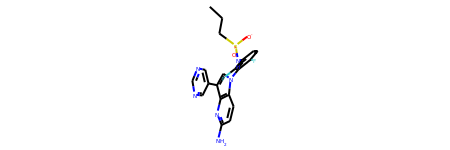

In [99]:
remote.coordinates.from_structure_id(12347, entity='ligand', output_format='rdkit', compute2d=False)

__Local__

Analog to remote version.

#### Ligand from file

__Remote__

Not implemented, since files live only locally.

__Local__

In [100]:
filepath = PATH_KLIFS_DOWNLOAD / "HUMAN/BRAF/6uuo_chainA/ligand.mol2"
local.coordinates.from_file(filepath)

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,residue.name,residue.pdb_id
0,1,C11,3.5395,20.5508,39.1755,C.ar,1,QH1,-0.0230,QH1,
1,2,C13,2.1865,20.1689,41.3174,C.2,1,QH1,-0.3016,QH1,
...,...,...,...,...,...,...,...,...,...,...,...
47,48,O06,4.5923,23.7237,34.2331,O.3,1,QH1,-0.6500,QH1,
48,49,S04,3.2962,22.7269,34.3426,S.o,1,QH1,1.3328,QH1,


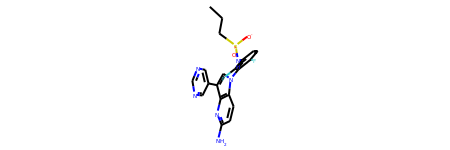

In [101]:
filepath = PATH_KLIFS_DOWNLOAD / "HUMAN/BRAF/6uuo_chainA/ligand.mol2"
local.coordinates.from_file(filepath, output_format="rdkit", compute2d=False)

### Protein

#### Protein from structure ID

__Remote__

In [102]:
remote.coordinates.from_structure_id(12347, entity='protein')

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,atom.backbone,residue.name,residue.pdb_id,residue.klifs_id,residue.klifs_region
0,1,N,10.5459,36.4276,36.2952,N.4,1,TRP450,1.0,BACKBONE,TRP,450,NaN,NaN
1,2,H1,11.3045,36.9642,36.6910,H,1,TRP450,0.0,BACKBONE,TRP,450,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3550,3551,OG,-31.7373,22.1137,37.9948,O.3,254,SER722,0.0,None,SER,722,NaN,NaN
3551,3552,HG,-31.8125,21.5936,37.1914,H,254,SER722,0.0,None,SER,722,NaN,NaN


__Local__

Analog to remote version.

#### Protein from file

__Remote__

Not implemented, since files live only locally.

__Local__

In [103]:
filepath = PATH_KLIFS_DOWNLOAD / "HUMAN/BRAF/6uuo_chainA/protein.mol2"
local.coordinates.from_file(filepath)

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,atom.backbone,residue.name,residue.pdb_id
0,1,N,10.5459,36.4276,36.2952,N.4,1,TRP450,1.0,BACKBONE,TRP,450
1,2,H1,11.3045,36.9642,36.6910,H,1,TRP450,0.0,BACKBONE,TRP,450
...,...,...,...,...,...,...,...,...,...,...,...,...
3550,3551,OG,-31.7373,22.1137,37.9948,O.3,254,SER722,0.0,None,SER,722
3551,3552,HG,-31.8125,21.5936,37.1914,H,254,SER722,0.0,None,SER,722


### Pocket

#### Pocket from structure ID

__Remote__

In [104]:
remote.coordinates.from_structure_id(12347, entity='pocket')

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,atom.backbone,residue.name,residue.pdb_id,residue.klifs_id,residue.klifs_region
0,1,N,9.0135,18.2386,51.8602,N.3,1,GLN461,0.00,BACKBONE,GLN,461,1,I.1
1,2,H,8.2695,18.7862,52.2683,H,1,GLN461,0.00,BACKBONE,GLN,461,1,I.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,1155,CZ,0.3114,24.3324,31.3839,C.ar,78,PHE595,-0.15,None,PHE,595,82,xDFG.82
1155,1156,HZ,0.0812,25.3190,31.7581,H,78,PHE595,0.15,None,PHE,595,82,xDFG.82


__Local__

Analog to remote version.

#### Pocket from file

__Remote__

Not implemented, since files live only locally.

__Local__

In [105]:
filepath = PATH_KLIFS_DOWNLOAD / "HUMAN/BRAF/6uuo_chainA/pocket.mol2"
local.coordinates.from_file(filepath).head()

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,atom.backbone,residue.name,residue.pdb_id,residue.klifs_id,residue.klifs_region
0,1,N,9.0135,18.2386,51.8602,N.3,1,GLN461,0.0,BACKBONE,GLN,461,1,I.1
1,2,H,8.2695,18.7862,52.2683,H,1,GLN461,0.0,BACKBONE,GLN,461,1,I.1
2,3,CA,8.8107,16.8107,51.6561,C.3,1,GLN461,0.0,BACKBONE,GLN,461,1,I.1
3,4,HA,9.7186,16.2932,51.9661,H,1,GLN461,0.0,BACKBONE,GLN,461,1,I.1
4,5,C,8.5594,16.4924,50.1864,C.2,1,GLN461,0.0,BACKBONE,GLN,461,1,I.1


### Water/ions

#### Water/ions from structure ID

__Remote__

In [106]:
try:
    remote.coordinates.from_structure_id(12347, entity='water')
except ValueError as e:
    print(e)

Entity water is not available remotely.


__Local__

In [107]:
local.coordinates.from_structure_id(12347, entity='water')

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,residue.name,residue.pdb_id
0,1,O,-29.7742,11.3869,19.8824,O.3,1,HOH,0.0,HOH,
1,2,H1,-28.8142,11.3869,19.8824,H,1,HOH,0.0,HOH,
2,3,H2,-30.0645,12.0339,20.5295,H,1,HOH,0.0,HOH,


#### Water/ions from file

__Remote__

Not implemented, since files live only locally.

__Local__

In [108]:
filepath = PATH_KLIFS_DOWNLOAD / "HUMAN/BRAF/6uuo_chainA/water.mol2"
local.coordinates.from_file(filepath).head()

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,residue.name,residue.pdb_id
0,1,O,-29.7742,11.3869,19.8824,O.3,1,HOH,0.0,HOH,
1,2,H1,-28.8142,11.3869,19.8824,H,1,HOH,0.0,HOH,
2,3,H2,-30.0645,12.0339,20.5295,H,1,HOH,0.0,HOH,


## Coordinates (save)

Save coordinates from remote.

```python
def to_file(
    structure_id,
    output_path,
    entity="complex",
    input_format="mol2",
    in_dir=False,
)
```
- `structure_id`: KLIFS structure ID.
- `output_path` : Path to output folder.
- `entity`: Structural entity: "complex" (default), "ligand", "pocket", or "protein". Locally also sometimes "water" and "ions".
- `input_format`: Input file format (fetched from KLIFS): "mol2" (default) or "pdb" (only for `entity="complex"`).
- `in_dir`: Save file in KLIFS directory structure (default: `False`).        

__Remote__

Default as show case: Save the complex coordiantes as _mol2_ file...

... without reproducing the KLIFS download directory structure:

In [109]:
remote.coordinates.to_file(12347, ".")

HUMAN_BRAF_6uuo_chainA_complex.mol2


... while reproducing the KLIFS download directory structure:

In [110]:
remote.coordinates.to_file(12347, ".", in_dir=True)

HUMAN/BRAF/6uuo_chainA/complex.mol2


Cleaning up after ourselves...

In [111]:
filepaths = [Path("HUMAN_BRAF_6uuo_chainA_complex.mol2"), Path("HUMAN/BRAF/6uuo_chainA/complex.mol2")]
[filepath.unlink(missing_ok=False) for filepath in filepaths]

[None, None]

__Local__

Not implemented, since files are already locally available.